### To do 

gal['data'].shape = 3, npix, npix -> gal['img'], gal['mask'], gal['weight'].   'mask' needs to be boolean.

In [48]:
import matplotlib as mpl
import numpy as np
from glob import glob
import matplotlib.pyplot as plt 
import pickle

import time
import random
import importlib
import os

mpl.rcParams['savefig.facecolor'] = 'white'


## AX
from ax.utils.notebook.plotting import render, init_notebook_plotting
from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.ax_client import AxClient

#
import astrobf
from astrobf.utils import mask_utils
from astrobf.utils.mask_utils import *
from astrobf.utils import gen_mask
from astrobf.morph import measure_morph

from astrobf.run import Full_exp
from astrobf.analysis.binary_clustering import *
from astrobf.analysis.utils import *

from astrobf.morph import custom_morph
from astrobf.analysis import multi_clustering as mucl
from astrobf.analysis.multi_clustering import labeler

## 1. Load the all-in-one data

### All_gals data

all-gals is a list of dictionaries, each of which contains 
(ndarray image, string image_name, and slices slice)


In [2]:
fn = "../../bf_data/Nair_and_Abraham_2010/all_gals.pickle"
all_gals = pickle.load(open(fn, "rb"))

all_gals = all_gals[1:] # Why the first galaxy image is NaN?

### 2. Load galaxy catalog data and initial morph measurements

Just in case, only for the initial morphology measurement, full results are saved. 

In [3]:
from astrobf.utils.misc import load_Nair
importlib.reload(astrobf.utils.misc)

cat_data = load_Nair('../../bf_data/Nair_and_Abraham_2010/catalog/table2.dat')
# pd dataframe

good_gids = np.array([gal['img_name'] for gal in all_gals])
cat = cat_data[cat_data['ID'].isin(good_gids)]
# Leave only needed fields.

# Run Bayesian Optimization loop

### Initialize BO loop -  Measure morphology features

In [7]:
## Runtime config.

fields = ['gini', 'm20']#, 'concentration', 'asymmetry', 'smoothness']
label_field = 'TT'

cluster_method='ward'
ngroups = 6
exp_dir=f'./G{ngroups}_Ward_test/'
if not os.path.isdir(exp_dir): os.mkdir(exp_dir)
fn_result = f'FMS_{ngroups}G_ward700'

this_bin, bin_mask = mucl.gen_bin_n_mask(ngroups)    
ax_params = mucl.gen_tmo_param_sets(ngroups)        
subcat = mucl.sample_in_bins(cat, ngroups, this_bin)
sub_gals = [gal for gal in all_gals if gal['img_name'] in subcat['ID']]

## Load results
#axc = AxClient.load_from_json_file(exp_dir+fn_result+'.json')

/home/hoseung/anaconda3/envs/tm39/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/hoseung/anaconda3/envs/tm39/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Catalog에서 outlier를 버렸으므로 원래의 catalog/all_gals보다 길이가 짧은 result_arr가 나옴. 
시작할 때 sample을 정하고, 나머지는 잘라버린 뒤에 optimization을 수행하는게 맞을 듯. 

그럼 good_gids도 업데이트해야됨. 


이거 머리 아프니까 한 덩어리로 합치면 좋겠는데.! 

# concentration / Asymmetry TEST BED

In [10]:
from astrobf.morph.custom_morph import gini, m20
def step_simple_morph(all_data,  
                      tmo_params, 
                      ind=None,
                      eps=1e-6,
                      do_plot=False,
                      fields = ['gini', 'm20']):
    """
    Parameters
    ----------
    all_data : list of dictionary {'data':data, 'img_name':img_name, 'slices':slices}
    tmo_params: iterable of parameteres [b, c, dl, dh] for Mantiuk_Seidel08 TMO.

    Return:
        an nd array for success, ['bad', sum of flux] list for fail.
        keep both iterable!
    """
    if ind is None:
        ind = np.arange(len(all_data))
        ngal = len(all_data)
    else:
        ngal = len(ind)

    result_arr = np.zeros(ngal, 
                      dtype=[('id','<U24'),('ttype',int), ('size', float)]
                           +[(ff,float) for ff in fields])
    
    for i, ii in enumerate(ind):
        this_gal = all_data[ii]
        img, mask, weight = this_gal['data']
        mask = mask.astype(bool)
        # clean up
        img[~mask] = np.nan
        img[img < 0] = 0
        #img *= 100 # MS08's generic TMs work best for pixels in (1e-2, 1e4)
        img /= np.nanmax(img) / 1e2
        tonemapped = Mantiuk_Seidel(img, **tmo_params)
        if np.sum(tonemapped) <= 0:
            return ['bad', np.sum(tonemapped)]
        result_arr[i]['id'] = this_gal['img_name']
        result_arr[i]['gini'] = gini(tonemapped, mask)
        result_arr[i]['m20']  = m20(tonemapped, mask)
        if result_arr[i]['gini'] < -90 or result_arr[i]['m20'] < -90:
            return ['bad', np.sum((result_arr[i]['gini'],result_arr[i]['m20']))]
    return result_arr

In [5]:
import photutils
import skimage

In [14]:
# parameters
annulus_width = 1.0 # 1pixel

In [47]:
#
# Eeach TM curve depends on the input image. 
# You CANNOT construct it once and apply for all images!
class Mantiuk_Seidel_c():
    
    def __init__(self, b,c,dl,dh):
        """
        Condition:
            * b - dl < max(lp) = 0.45
            * b + dh > min(lp)
        """
        al = (c*dl-1)/dl # contrast compression for shadows
        ah = (c*dh-1)/dh
        lp = np.log10(lum) # L prime

        conditions=[lp <= b-dl,
                    (b-dl < lp) * (lp <= b),
                    (b < lp) * (lp <= b+dh),
                    lp > b+dh]

        functions=[0,
                   lambda lp : 1/2*c*(lp-b)/(1-al*(lp-b))+1/2,
                   lambda lp : 1/2*c*(lp-b)/(1+ah*(lp-b))+1/2,
                   1]

        self.fun = np.piecewise(lp, conditions, functions)
    
    def eval(self, img):
        pass

In [52]:
class MorphImg():
    def __init__(self, subgal):
        self._img, self._segmap, self._weight = subgal
        self._preprocess()
        
        self._xc = 0
        self._yc = 0
        
        self._xc_asym = 0
        self._yc_asym = 0
        
        # Target properties
        self.r20 = 0
        self.r80 = 0
        self.M20 = 0
        self.Gini = 0
        self.Asym = 0
        self.Conc = 0
        self.Smooth=0
    
    def check_data(self):
        pass
    
    def measure_all(self):
        self.cal_moments()
        self.cal_gini()
        self.cal_m20()

    def _preprocess(self):
        """
        assign masked area nan or 0?
        """
        image = self._img

        self._segmap = self._segmap.astype(bool)
        image[~self._segmap] = np.nan
        image[image < 0] = 0 
        image /= np.nanmax(image) / 1e2
        self._tonemapped = Mantiuk_Seidel(image, **tmo_params)
    
    def cal_moments(self):
        """
        
        """
        
        self._cal_moments_1()
        self._cal_moments_2()
        
        
    
    def _cal_moments_1(self):
        image = self._tonemapped
        M = skimage.measure.moments(image, order=1)
        if M[0, 0] <= 0:
            #warnings.warn('[deviation] Nonpositive flux within Gini segmap.'
            #              AstropyUserWarning)
            print('[deviation] Nonpositive flux within Gini segmap.')
            return -99.0  # invalid
        self.yc = M[1, 0] / M[0, 0]
        self.xc = M[0, 1] / M[0, 0]
        self._M = M
    
    def _cal_moments_2(self):
        self._Mc = skimage.measure.moments_central(self._img, 
                                                 center=(self.yc, self.xc), 
                                                 order=2)
    
    
    def cal_gini(self):
        """
        Calculate the Gini coefficient as described in Lotz et al. (2004).
        """
        image = self._tonemapped
        segmap = self._segmap        
        
        sorted_pixelvals = np.sort(np.abs(image[segmap]))
        n = len(sorted_pixelvals)
        if n <= 1 or np.sum(sorted_pixelvals) == 0:
            #warnings.warn('[gini] Not enough data for Gini calculation.',
                          #AstropyUserWarning)
            print('[gini] Not enough data for Gini calculation.')

            return False  # invalid

        indices = np.arange(1, n+1)  # start at i=1
        self.Gini = (np.sum((2*indices-n-1) * sorted_pixelvals) /
                (float(n-1) * np.sum(sorted_pixelvals)))


    def cal_m20(self, centers=None):
        """
        Calculate the M_20 coefficient as described in Lotz et al. (2004).

        parameters
        ----------
        centers : center of image; (xc, yc) 
                Be careful of the order. 


        """
        image = self._tonemapped
        segmap = self._segmap
        xc, yc = self._xc, self._yc
        if np.sum(segmap) == 0:
            return -99.0  # invalid

        # Use the same region as in the Gini calculation
        image = np.float64(image)  # skimage wants double
        
        # Calculate second total central moment
        Mc = skimage.measure.moments_central(image, center=(yc, xc), order=2)
        second_moment_tot = Mc[0, 2] + Mc[2, 0]

        # Calculate threshold pixel value
        sorted_pixelvals = np.sort(image.flatten())
        flux_fraction = np.cumsum(sorted_pixelvals) / np.sum(sorted_pixelvals)
        sorted_pixelvals_20 = sorted_pixelvals[flux_fraction >= 0.8]
        if len(sorted_pixelvals_20) == 0:
            print('[m20] Not enough data for M20 calculation. Too few pixels')
            return -99.0  # invalid
        threshold = sorted_pixelvals_20[0]

        # Calculate second moment of the brightest pixels
        image_20 = np.where(image >= threshold, image, 0.0)
        Mc_20 = skimage.measure.moments_central(image_20, center=(yc, xc), order=2)
        second_moment_20 = Mc_20[0, 2] + Mc_20[2, 0]

        if (second_moment_20 <= 0) | (second_moment_tot <= 0):
            print('[m20] Negative second moment(s).')
            self.M20 = -99.0  # invalid
        else:
            self.M20 = np.log10(second_moment_20 / second_moment_tot)
            
    def print_props(self):
        props = ['r20', 'r80', 'M20', 'Gini', 'Asym', 'Conc', 'Smooth']
        for prp in props:
            print(prp, getattr(self, prp))
    

In [54]:
mi = MorphImg(sub_gals[0]['data'])

mi.measure_all()
mi.print_props()

NameError: name 'tmo_params' is not defined

In [ ]:
image, mask, www = sub_gals[0]['data']


image = np.float64(image)  # skimage wants double

# Calculate centroid
M = skimage.measure.moments(image, order=1)
if M[0, 0] <= 0:
    #warnings.warn('[deviation] Nonpositive flux within Gini segmap.'
    #              AstropyUserWarning)
    print('[deviation] Nonpositive flux within Gini segmap.')
#        return -99.0  # invalid
yc = M[1, 0] / M[0, 0]
xc = M[0, 1] / M[0, 0]


# Calculate second total central moment
Mc = skimage.measure.moments_central(image, center=(yc, xc), order=2)
second_moment_tot = Mc[0, 2] + Mc[2, 0]

# Calculate threshold pixel value
sorted_pixelvals = np.sort(image.flatten())
flux_fraction = np.cumsum(sorted_pixelvals) / np.sum(sorted_pixelvals)
sorted_pixelvals_20 = sorted_pixelvals[flux_fraction >= 0.8]
if len(sorted_pixelvals_20) == 0:
    print('[m20] Not enough data for M20 calculation. Too few pixels')
#    return -99.0  # invalid
threshold = sorted_pixelvals_20[0]

# Calculate second moment of the brightest pixels
image_20 = np.where(image >= threshold, image, 0.0)
Mc_20 = skimage.measure.moments_central(image_20, center=(yc, xc), order=2)
second_moment_20 = Mc_20[0, 2] + Mc_20[2, 0]

m20 = np.log10(second_moment_20 / second_moment_tot)
print("M20", m20)
########## M20

In [89]:
importlib.reload(astrobf.morph.statmorph)

<module 'astrobf.morph.statmorph' from '/home/hoseung/Work/tonemap/astroBF/astrobf/morph/statmorph.py'>

In [9]:
from astrobf.morph import statmorph

image, mask, weight = sub_gals[0]['data']
morph = statmorph.SourceMorphology(image, mask, weightmap=weight)

AttributeError: 'SourceMorphology' object has no attribute 'label'

In [93]:
%autoreload 2

UsageError: Line magic function `%autoreload` not found.


In [91]:
statmorph.SourceMorphology?

### Petrosian radius

In [ ]:
# diagonal_distance = distance to the farthest unmasked point

def _rpetro_circ_generic(self, center):
    # Find appropriate range for root finder
    npoints = 100
    r_inner = self._annulus_width
    r_outer = self._diagonal_distance
    assert r_inner < r_outer
    dr = (r_outer - r_inner) / float(npoints-1)
    r_min, r_max = None, None
    r = r_inner  # initial value
    while True:
        if r >= r_outer:
            warnings.warn('[rpetro_circ] rpetro larger than cutout.',
                          AstropyUserWarning)
            self.flag = 1
        curval = self._petrosian_function_circ(r, center)
        if curval >= 0:
            r_min = r
        elif curval < 0:
            if r_min is None:
                warnings.warn('[rpetro_circ] r_min is not defined yet.',
                              AstropyUserWarning)
                self.flag = 1
                if r >= r_outer:
                    # If r_min is still undefined at this point, then
                    # rpetro must be smaller than the annulus width.
                    warnings.warn('rpetro_circ < annulus_width! ' +
                                  'Setting rpetro_circ = annulus_width.',
                                  AstropyUserWarning)
                    return r_inner
            else:
                r_max = r
                break
        r += dr

    rpetro_circ = opt.brentq(self._petrosian_function_circ,
                             r_min, r_max, args=(center,), xtol=1e-6)

    return rpetro_circ

### Get Asym center

In [66]:
import scipy.optimize as opt

def asymmetry_function(center, image, mask, r):
    #image = np.float64(image)  # skimage wants double

    # Rotate around given center
    image_180 = skimage.transform.rotate(image, 180.0, center=center)

    # Apply symmetric mask
    #mask = self._mask_stamp.copy()
    mask_180 = skimage.transform.rotate(mask, 180.0, center=center)
    mask_180 = mask_180 >= 0.5  # convert back to bool
    mask_symmetric = mask | mask_180
    image = np.where(~mask_symmetric, image, 0.0)
    image_180 = np.where(~mask_symmetric, image_180, 0.0)

    ap = photutils.CircularAperture(center, r)

    # Apply eq. 10 from Lotz et al. (2004)
    ap_abs_sum = ap.do_photometry(np.abs(image), method='exact')[0][0]
    ap_abs_diff = ap.do_photometry(np.abs(image_180-image), method='exact')[0][0]

    if ap_abs_sum == 0.0:
        return 99.0  # invalid

    
    if _sky_asymmetry == -99.0:  # invalid skybox
        asym = ap_abs_diff / ap_abs_sum
    else:
        ap_area = _aperture_area(ap, mask_symmetric)
        asym = (ap_abs_diff - ap_area*self._sky_asymmetry) / ap_abs_sum

    return asym

In [69]:
center_0 = np.array([xc,yc])  # initial guess
#r = self._petro_extent_cas * self._rpetro_circ_centroid
r = 20
center_asym = opt.fmin(asymmetry_function, center_0, 
                       args=(image, mask.astype(bool),r),
                       xtol=1e-6, disp=True)
print(center_asym)

NameError: name 'self' is not defined

In [59]:
center_0

array([ 51.76886125,  44.63919435])

### 

In [19]:
from photutils.aperture import aperture_photometry

In [20]:
from photutils.aperture import EllipticalAnnulus, EllipticalAperture

In [24]:
from astropy import units

<ipython-input-57-47f3c3be38b6>:11: RuntimeWarning:

invalid value encountered in log10



(<matplotlib.patches.Ellipse at 0x7f3f6d287400>,)

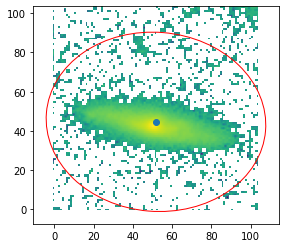

In [57]:
from photutils.morphology import data_properties

cat = data_properties(image)
r = 3.0  # approximate isophotal extent
a = cat.semimajor_sigma.value * r
b = cat.semiminor_sigma.value * r
theta = cat.orientation.to(units.rad).value

apertures = EllipticalAperture(center_asym, a, b, theta=theta)

plt.imshow(np.log10(image), origin='lower')
plt.scatter(*center_asym)
apertures.plot(color='red')

In [38]:
apertures.area

8032.433686469608

In [34]:
measure = aperture_photometry(image, apertures)

In [58]:
center_asym

array([ 51.76886125,  44.63919435])

In [36]:
xc, yc

(51.768861253760633, 44.639194352651309)

In [35]:
measure

id,xcenter,ycenter,aperture_sum
,pix,pix,
int64,float64,float64,float64
1,51.76886125376063,44.63919435265131,678.104738954


In [ ]:
def _quantile(sorted_values, q):
    """
    For a sorted (in increasing order) 1-d array, return the value
    corresponding to the quantile ``q``.

    Notes
    -----
    The result is identical to np.percentile(..., interpolation='lower'),
    but the currently defined function is infinitely faster for sorted arrays.
    """
    if q < 0 or q > 1:
        raise ValueError('Quantiles must be in the range [0, 1].')
    return sorted_values[int(q*(len(sorted_values)-1))]

def _aperture_area(ap, mask, **kwargs):
    """
    Calculate the area of a photutils aperture object,
    excluding masked pixels.
    """
    return ap.do_photometry(np.float64(~mask), **kwargs)[0][0]

def _aperture_mean_nomask(ap, image, **kwargs):
    """
    Calculate the mean flux of an image for a given photutils
    aperture object. Note that we do not use ``_aperture_area``
    here. Instead, we divide by the full area of the
    aperture, regardless of masked and out-of-range pixels.
    This avoids problems when the aperture is larger than the
    region of interest.
    """
    return ap.do_photometry(image, **kwargs)[0][0] / ap.area

In [17]:
########## R_petro ##########

r = r_initial = 1.0
center = center_initial = (xc, yc)

r_in = r - 0.5 * annulus_width
r_out = r + 0.5 * annulus_width

circ_annulus = photutils.CircularAnnulus(center, r_in, r_out)
circ_aperture = photutils.CircularAperture(center, r)

# Force mean fluxes to be positive:
circ_annulus_mean_flux = np.abs(aperture_mean_nomask(
    circ_annulus, image, method='exact'))
circ_aperture_mean_flux = np.abs(aperture_mean_nomask(
    circ_aperture, image, method='exact'))

NameError: name 'aperture_mean_nomask' is not defined

In [9]:
from functools import partial

def evaluate(params, cluster_method="agglomerate", eval_method='sample-weighted FMS'):
    plist =[{'b':params[f'b{i}'],
             'c':params[f'c{i}'],
            'dl':params[f'dl{i}'],
            'dh':params[f'dh{i}']} for i in range(ngroups)]


    result_arr = Full_exp.run_morph_in_parts(sub_gals, subcat, plist, ngroups)
    print("result_arr", result_arr)
    if result_arr == "bad":
        return {"mymetric": (-1, 0), "total_flux":(0,0)}
    Full_exp.add_ttype(result_arr, subcat)
    
    eval_metrics = Full_exp.do_ML(result_arr, partial(labeler, bins=this_bin), subcat, n_clusters=ngroups,
                                  fields=['gini', 'm20'], 
                                  cluster_method=cluster_method,
                                  eval_weight='area')
    
    # save all metrics to a global list.
    all_metrics.append(eval_metrics)
    #mymetric = eval_metrics[0][1] # Homogenity
    clustering_score = [val for (name, val) in eval_metrics if name == eval_method][0]
    stderr = 0.0
    return {"mymetric": (clustering_score, stderr), "total_flux":(1,0)}

In [14]:
importlib.reload(Full_exp)

<module 'astrobf.run.Full_exp' from '/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py'>

I don't want a masked array. Tonemapper eventually returns (after applying np.peicewise()) a ndarray.

1. skimage.measure.moments_central에서 masked array를 저절로 처리해주진 않음. 
2. mask 씌운 나머지에서만 moment 계산하는거 맞겠지? 

In [15]:
ax_params = []
for i in range(ngroups):
    ax_params.append(
        {"name":f"b{i}", "type":"range", "bounds":[1.5,8.0], "value_type":"float"})
    ax_params.append(
        {"name":f"c{i}", "type":"range", "bounds":[1.5,8.0], "value_type":"float"})
    ax_params.append(
        {"name":f"dl{i}", "type":"range", "bounds":[1.0,15.0], "value_type":"float"})
    ax_params.append(
        {"name":f"dh{i}", "type":"range", "bounds":[1.0,15.0], "value_type":"float"})

# 0.45x is the lowest value of maximum flux of all images.
exp_dir='./Experiments/'

In [16]:
for fn_result, cluster_method in zip([f"FMS_{ngroups}G_ward", f"FMS_{ngroups}G_agg", f"FMS_{ngroups}G_spec"][:2],
                                     ['ward', 'agglomerate', 'spectral'][:2]):

    axc = AxClient()

    axc.create_experiment(
        parameters=ax_params,
        objective_name="mymetric",
        #minimize=True,  # Optional, defaults to False.
        parameter_constraints=[f"b{i} - dl{i} <= 100" for i in range(ngroups)], # all images are stretched to 100
        overwrite_existing_experiment =True,
        outcome_constraints=["total_flux >= 1e-5"],  # Optional.
    )

    all_metrics=[]
    for i in range(500):
        parameters, trial_index = axc.get_next_trial()
        axc.complete_trial(trial_index=trial_index, raw_data=evaluate(parameters, cluster_method=cluster_method))
        if i % 50 == 49:
            print(f"{i}-th done")

    pickle.dump(all_metrics, open(exp_dir+fn_result+"_all_metrics.pickle", "wb"))

    if True:
        axc.save_to_json_file(exp_dir+fn_result+".json")
    else:
        axc = AxClient.load_from_json_file(exp_dir+fn_result+'.json')

[INFO 05-26 16:42:01] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 2 decimal points.
[INFO 05-26 16:42:01] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 24 trials, GPEI for subsequent trials]). Iterations after 24 will take longer to generate due to  model-fitting.
[INFO 05-26 16:42:01] ax.service.ax_client: Generated new trial 0 with parameters {'b0': 4.88, 'c0': 5.21, 'dl0': 11.62, 'dh0': 4.21, 'b1': 7.98, 'c1': 2.44, 'dl1': 1.36, 'dh1': 14.05, 'b2': 2.62, 'c2': 4.83, 'dl2': 2.23, 'dh2': 1.52, 'b3': 5.82, 'c3': 3.81, 'dl3': 7.87, 'dh3': 3.53, 'b4': 4.86, 'c4': 6.6, 'dl4': 4.4, 'dh4': 14.15, 'b5': 6.39, 'c5': 7.25, 'dl5': 10.91, 'dh5': 11.76}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10

/home/hoseu

result_arr bad


/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py:131: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

[INFO 05-26 16:42:10] ax.service.ax_client: Completed trial 1 with data: {'mymetric': (-1, 0), 'total_flux': (0, 0)}.
[INFO 05-26 16:42:10] ax.service.ax_client: Generated new trial 2 with parameters {'b0': 6.99, 'c0': 4.45, 'dl0': 8.31, 'dh0': 8.67, 'b1': 5.49, 'c1': 3.24, 'dl1': 8.56, 'dh1': 2.89, 'b2': 7.01, 'c2': 6.98, 'dl2': 1.02, 'dh2': 10.67, 'b3': 5.11, 'c3': 4.09, 'dl3': 13.77, 'dh3': 4.18, 'b4': 3.84, 'c4': 5.41, 'dl4': 6.41, 'dh4': 12.81, 'b5': 1.8, 'c5': 6.34, 'dl5': 5.52, 'dh5': 7.38}.


result_arr bad


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py:131: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



result_arr [('J000047.89p141639.09', 0,  0.,  0.11890664, -1.45202667)
 ('J000133.95p150453.64', 0,  0.,  0.2345289 , -1.13048153)
 ('J000200.82p150132.23', 0,  0.,  0.14995968, -1.55549151) ...,
 ('J235743.74p003918.61', 0,  0.,  0.21910756, -1.54619907)
 ('J235744.10m001029.94', 0,  0.,  0.14209924, -1.4860146 )
 ('J235929.61p161009.65', 0,  0.,  0.24026377, -1.64101213)]
Is every element matched?:  True


<ipython-input-9-a368a475235a>:12: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

[INFO 05-26 16:42:21] ax.service.ax_client: Completed trial 2 with data: {'mymetric': (0.71999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 05-26 16:42:21] ax.service.ax_client: Generated new trial 3 with parameters {'b0': 3.84, 'c0': 4.87, 'dl0': 3.48, 'dh0': 11.35, 'b1': 5.94, 'c1': 3.34, 'dl1': 14.36, 'dh1': 3.42, 'b2': 6.79, 'c2': 2.3, 'dl2': 10.25, 'dh2': 6.69, 'b3': 7.18, 'c3': 5.92, 'dl3': 7.18, 'dh3': 2.23, 'b4': 5.96, 'c4': 5.5, 'dl4': 2.87, 'dh4': 14.32, 'b5': 2.79, 'c5': 7.21, 'dl5': 9.81, 'dh5': 9.92}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py:131: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform 

result_arr bad


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py:131: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



result_arr [('J000047.89p141639.09', 0,  0.,  0.10389545, -1.42385518)
 ('J000133.95p150453.64', 0,  0.,  0.99877804, -1.2345181 )
 ('J000200.82p150132.23', 0,  0.,  0.27003347, -2.03139357) ...,
 ('J235743.74p003918.61', 0,  0.,  0.95735379, -1.91334845)
 ('J235744.10m001029.94', 0,  0.,  0.26462161, -1.9304842 )
 ('J235929.61p161009.65', 0,  0.,  0.38810744, -1.73875331)]
Is every element matched?:  True


<ipython-input-9-a368a475235a>:12: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

[INFO 05-26 16:42:37] ax.service.ax_client: Completed trial 4 with data: {'mymetric': (0.95999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-26 16:42:37] ax.service.ax_client: Generated new trial 5 with parameters {'b0': 6.19, 'c0': 2.43, 'dl0': 13.85, 'dh0': 9.96, 'b1': 6.89, 'c1': 4.1, 'dl1': 3.73, 'dh1': 10.81, 'b2': 2.49, 'c2': 3.66, 'dl2': 9.64, 'dh2': 7.26, 'b3': 7.32, 'c3': 2.64, 'dl3': 14.31, 'dh3': 11.79, 'b4': 1.73, 'c4': 7.29, 'dl4': 5.66, 'dh4': 4.96, 'b5': 5.62, 'c5': 7.76, 'dl5': 8.77, 'dh5': 13.43}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10



KeyboardInterrupt: 

In [64]:
all_metrics

[]

In [10]:
axc = AxClient.load_from_json_file(exp_dir+'FMS_6G_ward'+'.json')

[INFO 05-26 14:08:04] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 2 decimal points.


In [19]:
importlib.reload(Full_exp)

<module 'astrobf.run.Full_exp' from '/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py'>

In [12]:
fn_result = f"FMS_{ngroups}G_ward"

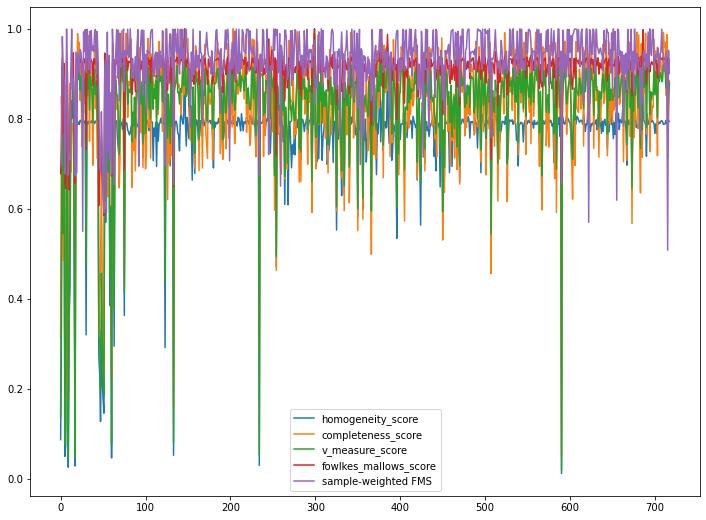

[INFO 05-26 11:50:42] ax.modelbridge.generation_strategy: Note that parameter values in dataframe are rounded to 2 decimal points; the values in the dataframe are thus not the exact ones suggested by Ax in trials.


     Generation Step Generation Model  Trial Index Trial Status  \
0                  0            Sobol            0    COMPLETED   
1                  0            Sobol            1    COMPLETED   
2                  0            Sobol            2    COMPLETED   
3                  0            Sobol            3    COMPLETED   
4                  0            Sobol            4    COMPLETED   
..               ...              ...          ...          ...   
995                1             GPEI          995    COMPLETED   
996                1             GPEI          996    COMPLETED   
997                1             GPEI          997    COMPLETED   
998                1             GPEI          998    COMPLETED   
999                1             GPEI          999    COMPLETED   

                                 Arm Parameterizations  
0    {'0_0': {'b0': 3.55, 'c0': 1.76, 'dl0': 5.89, ...  
1    {'1_0': {'b0': 1.56, 'c0': 6.76, 'dl0': 14.0, ...  
2    {'2_0': {'b0': 3.06

<Figure size 432x288 with 0 Axes>

In [24]:
fig, ax = plt.subplots()
fig.set_size_inches(12,9)
for i in [0,1,2,5,9]:
    values =[al[i][1] for al in all_metrics] 
    ax.plot(values / np.max(values), label=all_metrics[0][i][0])
ax.legend()
plt.show()
plt.savefig(fn_result+"param_evol.png")

print(axc.generation_strategy.trials_as_df)
render(axc.get_optimization_trace())

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10



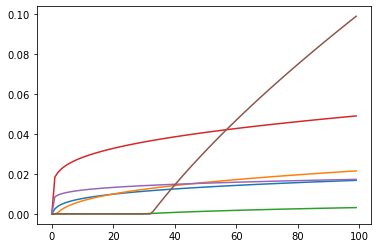

In [25]:
best_parameters, values = axc.get_best_parameters()
from astrobf.tmo import Mantiuk_Seidel
for i in range(ngroups):
    plt.plot(Mantiuk_Seidel(np.linspace(0,100,100), **mucl.ext_single_param(best_parameters, f"{i}")))
    

parameters들 normalize가 안 된듯?? 
각각의 모양은 그럴싸함. 

## Prototypical samples

In [14]:
from astrobf import analysis

best_parameters, values = axc.get_best_parameters()

plist = []
for i in range(ngroups):
    plist.append(mucl.ext_single_param(best_parameters, f"{i}"))
best_results = Full_exp.run_morph_in_parts(sub_gals, subcat, plist, ngroups)

#best_results = custom_morph.step_simple_morph(all_gals, best_parameters)
Full_exp.add_ttype(best_results, subcat)

best_eval_metrics, best_clustering = Full_exp.do_ML(best_results, partial(labeler, bins=this_bin), subcat,
                                         fields=['gini', 'm20'], 
                                         n_clusters=ngroups,
                                         return_cluster=True,
                                         cluster_method="ward",
                                         eval_weight='area')

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py:242: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 16013/7095
cluter_method ward
ward


7095


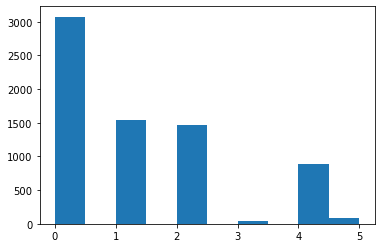

In [15]:
print(len(best_clustering.labels_))

plt.hist(best_clustering.labels_)
plt.show()

class1은 다 어디감?   
원래 있는 class를 나누는게 아니고, 알아서 4 그룹으로 나누게 하는 것.   
Unsupervised learning을 하던 중이었어..?   
Supervised로 해야되는거 아님? 

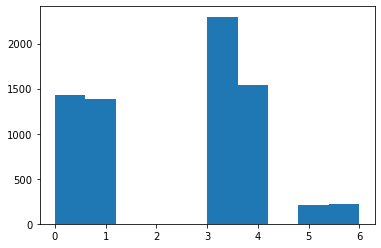

In [16]:
plt.hist(labeler(subcat, bins=this_bin, field='TT'))
plt.show()

# Get typicals

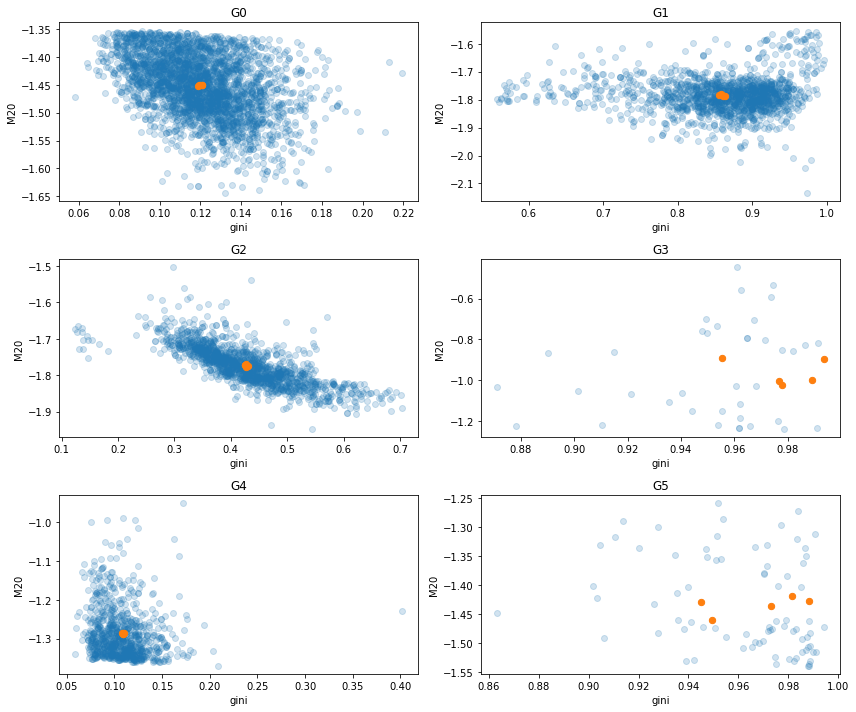

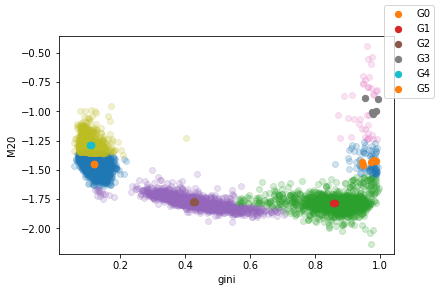

In [34]:
# Get centroids (typicals)
typicals = []

fig, axs = plt.subplots(3,2)
axs = axs.ravel()
fig.set_size_inches(12,10)

fig_sum, ax_sum = plt.subplots()
for i in range(ngroups):
    ax = axs[i]
    group = best_results[best_clustering.labels_ == i]
    
    t_ind = analysis.utils.get_typical_ind(group, n_samples=5)
    ax.scatter(group['gini'], group['m20'], alpha=0.2)
    ax.scatter(group['gini'][t_ind], group['m20'][t_ind], s=40)
    ax.set_xlabel("gini")
    ax.set_ylabel("M20")
    ax.set_title(f"G{i}")
    
    typicals.append([gal for gal in sub_gals if gal['img_name'] in group['id'][t_ind]])
    
    
    # all in one plot
    ax_sum.scatter(group['gini'], group['m20'], alpha=0.2)
    ax_sum.scatter(group['gini'][t_ind], group['m20'][t_ind], s=40, label=f"G{i}")
    ax_sum.set_xlabel("gini")
    ax_sum.set_ylabel("M20")


fig.tight_layout()
fig_sum.legend()
plt.show()

In [58]:
importlib.reload(mucl)

<module 'astrobf.analysis.multi_clustering' from '/home/hoseung/Work/tonemap/astroBF/astrobf/analysis/multi_clustering.py'>

In [59]:
mucl.plot_group_comparison(typicals, plist, ngroups, simple_log=False,
                          fn=fn_result+"groups_comp.png")
mucl.plot_group_comparison(typicals, plist, ngroups, simple_log=True,
                          fn=fn_result+"groups_log.png")

## Typical sampes at incremental points 

### Get the 'incremental' points

<ipython-input-37-ebfccd808eda>:24: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-37-ebfccd808eda>:24: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-37-ebfccd808eda>:24: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-37-ebfccd808eda>:24: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-37-ebfccd808eda>:24: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-37-ebfccd808eda>:24: UserWarning:

FixedFormatter should only be used together with FixedLocator



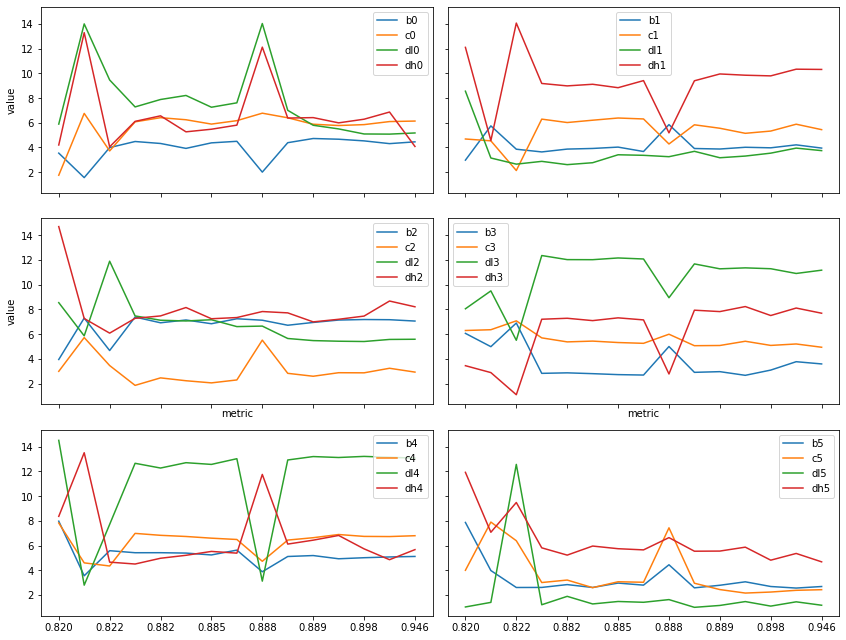

In [37]:
trace, t_ = axc.get_optimization_trace()

scores = np.array(trace['data'][0]['y'])
i_incr = [np.argmax(sc == scores) for sc in np.unique(scores)]

incr_params = [axc.get_trial_parameters(i) for i in i_incr]

# Change of the parameters over time
param_arr = np.zeros(len(incr_params), dtype=[(key, 'f') for key in incr_params[0].keys()])

for i, params in enumerate(incr_params):
    for key, val in params.items():
        param_arr[key][i] = val

fig,axs = plt.subplots(3,2, sharex=True, sharey=True)
fig.set_size_inches(12,9)
axs = axs.ravel()
for i in range(ngroups):    
    ax = axs[i]
    for field in param_arr.dtype.names:
        if f"{i}" in field:
            ax.plot(param_arr[field], label=field)

    ax.set_xticklabels([f"{scores[i]:.3f}" for i in i_incr])
    ax.legend()
axs[2].set_xlabel("metric")
axs[3].set_xlabel("metric")
axs[0].set_ylabel("value")
axs[2].set_ylabel("value")
plt.tight_layout()
plt.show()

Interestingly, the changes are somewhat unpredictable.

### Typical samples at each incremental point

TODO : support arbitrary numebr of clusters. 

In [162]:
importlib.reload(mucl)

<module 'astrobf.analysis.multi_clustering' from '/home/hoseung/Work/tonemap/astroBF/astrobf/analysis/multi_clustering.py'>

In [163]:
# Typicals defined above

clu_best = [best_results[best_clustering.labels_ == i] for i in range(ngroups)] 
typical_best_results = [analysis.utils.get_matched_result(best_results, 
                                               [gal['img_name'] for gal in tt]) for tt in typicals]

for i, this_params in enumerate(incr_params):
    
    plist = [mucl.ext_single_param(this_params, f"{i}") for i in range(ngroups)]
    
    mucl.plot_group_comparison(typicals, plist, ngroups,
                          fn=f'typical_{i}.png',
                          suptitle=f"scroe: {scores[i_incr[i]]:.4f}")

    this_results = Full_exp.run_morph_in_parts(sub_gals, subcat, plist, ngroups)
    Full_exp.add_ttype(this_results, subcat)

    eval_metrics, this_clustering = Full_exp.do_ML(this_results, partial(labeler, bins=this_bin), subcat,
                                     fields=['gini', 'm20'], 
                                     n_clusters=ngroups,
                                     return_cluster=True,
                                     cluster_method=cluster_method,
                                     eval_weight='area')

    typical_this_results = [(analysis.utils.get_matched_result(this_results, 
                                               [gal['img_name'] for gal in tt])) for tt in typicals]
    clu_this = [this_results[this_clustering.labels_ == i] for i in range(ngroups)] 
    mucl.plot_group_evals_w_centers(clu_best, 
                           typical_best_results,
                           clu_this, 
                           typical_this_results,
                           fn=f"G_M{i}.png")

    mucl.plot_classification_vs_answer(this_results, clu_best, partial(labeler, bins=this_bin),
                                    fn=f"current_in_best_color{i}.png")

/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py:242: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 9607/7095
cluter_method agglomerate
agg
# labels [0 2 3 4]


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py:242: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 9607/7095
cluter_method agglomerate
agg
# labels [0 2 3 4]


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10



KeyboardInterrupt: 